# Navigation

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

In [2]:
from unityagents import UnityEnvironment
import numpy as np

# please do not modify the line below
env = UnityEnvironment(file_name="/data/Banana_Linux_NoVis/Banana.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

env_info = env.reset(train_mode=True)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
state_size = len(state)
action_size = brain.vector_action_space_size

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of actions
action_size = brain.vector_action_space_size
#print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
state_size = len(state)

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import random
import numpy as np
from collections import namedtuple, deque
import matplotlib.pyplot as plt

In [6]:
#define variables

BUFFER_SIZE = int(1e7)
BATCH_SIZE = 64
GAMMA = 0.98
TAU = 1e-3
LR = 0.0001
UPDATE_EVERY = 5

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [7]:
#FC Neural Network Layer

class QNetwork(nn.Module):
    def __init__(self, state_size, action_size, seed):
        super(QNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, action_size)
     
    #Forward Prop
    def forward(self, state):
        
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        
        return x
            

In [8]:
#Primary Agent Class

class Agent():
    
    def __init__(self, state_size, action_size, seed):
        
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)
        
        #Q
        
        self.qnetwork_local = QNetwork(state_size, action_size, seed).to(device)
        self.qnetwork_target = QNetwork(state_size, action_size, seed).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)
        
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)
        self.t_step = 0
        
    def step(self, state, action, reward, next_state, done):
        #save exp in replay memory
        self.memory.add(state, action, reward, next_state, done)
        
        #update at timesteps
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:
            if len(self.memory) > BATCH_SIZE:
                experiences = self.memory.sample()
                self.learn(experiences, GAMMA)
            
    def act(self, state, eps=0.):
        
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()
        
        #eps greedy selection
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))
        
    def learn(self, experiences, gamma):
        
        states, actions, rewards, next_states, dones = experiences
        
        #max Q for next state
        Q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
        
        #Q targets for current state
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones)) 
        
        #get expected Qs from local model
        Q_expected = self.qnetwork_local(states).gather(1 , actions)
        
        #compute loss
        loss = F.mse_loss(Q_expected, Q_targets)
        
        #backprop
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        
        #update network
        self.soft_update(self.qnetwork_local, self.qnetwork_target, TAU)
            
    def soft_update(self, local_model, target_model, tau):   
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau* local_param.data + (1.0-tau)*target_param.data)
            
class ReplayBuffer:
    
    def __init__(self, action_size, buffer_size, batch_size, seed):
        
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
        
    def add(self, state, action, reward, next_state, done):
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        
        experiences = random.sample(self.memory, k=self.batch_size)
        
        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
        
        return (states, actions, rewards, next_states, dones)
    
    def __len__(self):
        return len(self.memory)
    
    

In [9]:
def dqn(agent, n_episodes=2000, max_t=1000, eps_start = 1.0 , eps_end=0.0001, eps_decay=0.01, train=True):
    
    #train
    scores = []
    scores_window = deque(maxlen=100)
    eps = eps_start
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name] # reset the environment
        state = env_info.vector_observations[0]            # get the current state
        score = 0

        #DEFINE ENV SPACE
        for t in range(max_t): 
            action = agent.act(state, eps if train else 0.0)
            env_info = env.step(action)[brain_name]        # send the action to the environment
            next_state = env_info.vector_observations[0]   # get the next state
            reward = env_info.rewards[0]                   # get the reward
            done = env_info.local_done[0]                  # see if episode has finished
            if train:   
                agent.step(state, action, reward, next_state, done)
            score += reward                                # update the score
            state = next_state                             # update the state

            if done:
                break
                
        #Track Average Scores Every 100 Episodes
        scores_window.append(score)
        scores.append(score)
        eps = max(eps_end, eps_decay*eps)
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=13.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
            break
    return scores

In [10]:
#Instantiate Agent
agent = Agent(state_size=state_size, action_size=action_size, seed=0)
score = dqn(agent)

Episode 100	Average Score: 2.19
Episode 200	Average Score: 4.61
Episode 300	Average Score: 8.93
Episode 400	Average Score: 11.60
Episode 422	Average Score: 13.01
Environment solved in 322 episodes!	Average Score: 13.01


<function matplotlib.pyplot.show(*args, **kw)>

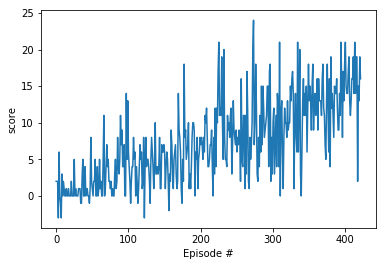

In [11]:
#Score Plot
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(score)), score)
plt.ylabel('score')
plt.xlabel('Episode #')
plt.show